# MNIST 손글씨 - CNN v3
- 2 Conv2D layers
- 1 MaxPooling2D layer
- 1 Dropout(0.25) layer 
    - 어떤 층의 뒤에 드롭아웃을 두어 이 층의 출력을 랜덤하게 0으로 만든다.
        - 드롭아웃이 층처럼 사용되지만 훈련되는 모델 파라미터는 없다.
        - 드롭아웃 층은 훈련되는 모델 파라미터가 없고, 입력과 출력의 크기가 같다.
        - 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지는 않는다. 
    - 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 (즉 뉴런의 출력을 0으로 만들어) 과대적합을 막는다.
        - 훈련 중에 적용되며 평가나 예측에서는 적용하지 않는다. ==> 텐서플로는 이를 자동으로 처리한다. 
    - 뉴런은 랜덤하게 드롭아웃되고 얼마나 많은 뉴런을 드롭할지는 우리가 정해야 할 또 다른 하이퍼 파라미터!
    - 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 주의를 기울여야 한다.
    - cf. Ensemble: ML에서 과대적합을 막아주는 아주 좋은 기법
- 1 Fully Connected Network layer
- 1 Dropout(0.5)
- 1 Output layer

In [3]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 전처리

In [4]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
# X data: 0~1 사이의 값, 3차원 --> 4차원
X_train = X_train.reshape(-1,28,28,1) / 255.
X_test = X_test.reshape(-1,28,28,1) / 255.

In [6]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

- 모델 정의/학습/평가

In [7]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
model = Sequential([
    Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),   
    MaxPooling2D(),                         # MaxPooling2D(pool_size=(2,2))     
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               4719104   
                                                        

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model_path = 'best-mnist-cnn-v3.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

In [11]:
hist = model.fit(
    X_train, Y_train, validation_split=0.2, epochs=100, batch_size=200,
    callbacks=[checkpoint, early_stop], verbose=0
)


Epoch 00001: val_loss improved from inf to 0.05647, saving model to best-mnist-cnn-v3.h5

Epoch 00002: val_loss improved from 0.05647 to 0.04937, saving model to best-mnist-cnn-v3.h5

Epoch 00003: val_loss improved from 0.04937 to 0.03931, saving model to best-mnist-cnn-v3.h5

Epoch 00004: val_loss improved from 0.03931 to 0.03730, saving model to best-mnist-cnn-v3.h5

Epoch 00005: val_loss improved from 0.03730 to 0.03684, saving model to best-mnist-cnn-v3.h5

Epoch 00006: val_loss improved from 0.03684 to 0.03331, saving model to best-mnist-cnn-v3.h5

Epoch 00007: val_loss did not improve from 0.03331

Epoch 00008: val_loss improved from 0.03331 to 0.03289, saving model to best-mnist-cnn-v3.h5

Epoch 00009: val_loss did not improve from 0.03289

Epoch 00010: val_loss did not improve from 0.03289

Epoch 00011: val_loss did not improve from 0.03289

Epoch 00012: val_loss did not improve from 0.03289

Epoch 00013: val_loss did not improve from 0.03289

Epoch 00014: val_loss did not imp

In [12]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0289 - accuracy: 0.9910


[0.02894221432507038, 0.9909999966621399]

- 훈련과정 시각화

In [13]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

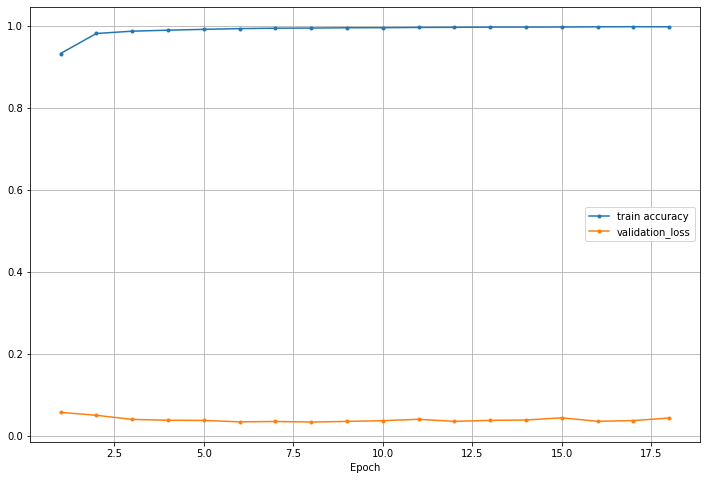

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, 'o-', ms=3,  label='train accuracy')
plt.plot(xs, y_vloss, 'o-', ms=3, label='validation_loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()